# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Google Collab Set Up

Ignore if you are not using Google Collab

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/My Drive
!git clone https://github.com/waggle-sensor/sage-vectordb-example.git
%cd sage-vectordb-example
!git pull
!git checkout main
%cd INQUIRE_benchmark/results

# Evaluating INQUIRE Benchmarks 

Here we will evaluate the raw query metrics returned by INQUIRE_benchmark. These raw metrics were calculated using [INQUIRE-Benchmark-small](https://huggingface.co/datasets/sagecontinuum/INQUIRE-Benchmark-small) with our [Hybrid Search](../../../HybridSearch_example/) with a [CLIP](https://huggingface.co/apple/DFN5B-CLIP-ViT-H-14-378) variation named `DFN5B-CLIP-ViT-H-14-378` trained on a dataset filtered by a [Data Filtering Network (DFN)](https://arxiv.org/abs/2309.17425) and set to **response_limit=50**. This means it will return up to 50 images. This was configured this way because INQUIRE uses the top 50 as well to benchmark models.

To better understand the results, each image is matched with a query in the dataset. Although not all matched images are relevant to the query.
>NOTE: INQUIRE also provies a [leaderboard](https://inquire-benchmark.github.io/). This is helpful for comparing our results.

This version tested [Hybrid Search](../../../HybridSearch_example/) with `align` integrated which included:

- **Florence 2 for Caption Generation**: Captions are generated for images using the Florence 2 model.
- **Vector Search**: Utilizes embeddings of both the images and their captions to perform semantic search on **CLIP's** imbedding space.
- **Keyword Search**: Searches are also performed using keywords extracted from image captions.
- **Hybrid Search**: A combination of vector and keyword searches to return the most relevant results.
- **Reranker**: A model that refines the order of search results, ensuring that the most relevant documents or items are ranked higher. It goes beyond the initial retrieval step, considering additional factors such as semantic similarity, context, and other relevant features.

Here were the Hyperparameters:

```py
from weaviate.classes.query import HybridFusion
from weaviate.classes.config import VectorDistances, Configure
from weaviate.collections.classes.config_vector_index import VectorFilterStrategy

# 1) Hybrid Search Query hyperparameters
response_limit=50
query_alpha=0.4 
max_vector_distance=0.4
near_text_certainty=0.7
clip_alpha = 0.7

#Florence 2 hyperparameters
max_new_tokens=512 #Changed from 1024 to 512
early_stopping=False #Changed from False to True
do_sample=False
num_beams=2 #changed from 3 to 2

# 3) clip module weights
clip_alpha = 0.7

# 4) Hierarchical Navigable Small World (hnsw) for Approximate Nearest Neighbor (ANN) hyperparamaters
hnsw_dist_metric=VectorDistances.COSINE
hnsw_ef=-1
hnsw_ef_construction=100
hnsw_maxConnections=50
hsnw_dynamicEfMax=500
hsnw_dynamicEfMin=200
hnsw_ef_factor=20
hsnw_filterStrategy=VectorFilterStrategy.ACORN
hnsw_flatSearchCutoff=40000
hnsw_vector_cache_max_objects=1e12
hnsw_quantizer=Configure.VectorIndex.Quantizer.pq(
    training_limit=500000 #threshold to begin training
)
```

## Query and Image Collection Process

This explanation was grabbed from the [INQUIRE paper](https://arxiv.org/abs/2411.02537) so that we can better understand the results in further sections

### Query Collection
To ensure that INQUIRE comprises text queries that are relevant to scientists,
we conducted interviews with individuals across different ecological and environmental domains -
including experts in ornithology, marine biology, entomology, and forestry. Further queries were
sourced from reviews of academic literature in ecology. We retained only queries that (1) could be discerned from images
alone, (2) were feasible to comprehensively label over the entire iNat24 dataset, and (3) were of
interest to domain experts.

### Image Annotation
All image annotations were performed by a small set of individuals whose
interest and familiarity with wildlife image collections enabled them to provide accurate labels for
challenging queries. Annotators were instructed to label all candidate images as either relevant (i.e.,
positive match) or not relevant (i.e., negative match) to a query, and to mark an image as not relevant
if there was reasonable doubt. To allow for comprehensive labeling, where applicable, iNat24 species
labels were used to narrow down the search to a sufficiently small size to label all relevant images for
the query of interest. For queries in which species labels could not be used, labeling was performed
over the top CLIP ViT-H-14 retrievals alone. In this case, the resulting annotations were only
kept if we were certain that this labeling captured the vast majority of positives, including labeling
until at least 100 consecutive retrievals were not relevant. Queries that were deemed
too easy, not comprehensively labeled, or otherwise not possible to label were excluded from our
benchmark. In total, this process resulted in 250 queries which involved labeling 194,334 images, of
which 32,696 were relevant to their query.

### Query Categories
Each query belongs to one of four supercategories (appearance, behavior,
context, or species), and further into one of sixteen fine-grained categories (e.g., Animal Structures
and Habitats). We also note
queries that use scientific terminology, words typically used only within scientific contexts (e.g., “A
godwit performing distal rhynchokinesis”).

### Data Split
We divide all queries into 50 validation and 200 test queries using a random split,
stratified by category.

## Query Coverage

Queries cover a range of topics and a organism taxonomies:

![Query Coverage](https://github.com/waggle-sensor/sage-vectordb-example/blob/main/INQUIRE_benchmark/results/images/inquire_iconic_groups.png?raw=1)
![Query Coverage](https://github.com/waggle-sensor/sage-vectordb-example/blob/main/INQUIRE_benchmark/results/images/inquire_categories.png?raw=1)

## Query Metric Dataset

Each row in the dataframe is evaluating a query used in our image search system:
- **query_id**: an ID given to each unique query in the dataset
- **query**: The query inserted into our image search. These are the same queries created by the INQUIRE authors.
- **total_images**: The total images returned from our image search using the specified query.
- **correctly_returned**: The number of images returned that matched with the query indicated in the dataset. For example, if the query was "apple" for the image in the dataset and I used the query "apple" in our image search system. The image returned would be marked as correctly returned since the queries matched.
- **incorrectly_returned**: The number of images returned that did NOT match with the query in the dataset. Using the example above, if we used the query "banana" in our image search system and the image retured had a query of "apple" in the dataset then this will be marked as incorreclt returned.
- **relevant_images**: The number of images returned marked as relevant. Each image in the dataset is marked as relevant or nonrelavent to the query it is matched with.
- **non_relevant_images**: The number of images returned marked as nonrelevant. Each image in the dataset is marked as relevant or nonrelavent to the query it is matched with.
- **accuracy**: The number of images correctly returned compared to the total images.
- **precision**: The number of relevant images returned compared to the total images.
- **recall**: The number of relevant images returned compared to the number of relevant images in the dataset.
- **NDCG**: A metric used to evaluate a rerank model. A higher score means relevant images were given a higher score than nonrelevant images.
- **clip_NDCG**: NDCG was also calculated for the clip scores given in the dataset. This column can be used as a comparison to the column NDCG. CLIP ViT-H-14 was used by the INQUIRE authors to provide a rerank score for each image. If NDCG is higher than this column, that means our image search system is doing better.
- **category**: The category given to the query by the INQUIRE authors. (ex; Defensive and Survival Behaviors)
- **supercategory**: The supercategory given the the query by the INQUIRE authors. (ex; Behavior)
- **iconic_group**: The iconic group given to the query by the INQUIRE authors. (ex; Mammals)


In [2]:
#load in metric data
df = pd.read_csv('query_eval_metrics.csv')
df

,query_id,query,total_images,correctly_returned,incorrectly_returned,relevant_images,non_relevant_images,accuracy,precision,recall,NDCG,clip_NDCG,category,supercategory,iconic_group
0,11,A mongoose standing upright alert,50,50,0,17.0,33.0,1.00,0.34,0.653846,0.649615,0.967030,Defensive and Survival Behaviors,Behavior,Mammals
1,189,puffins carrying food,50,44,6,5.0,45.0,0.88,0.10,0.625000,0.735202,0.764588,Feeding and Hydration,Behavior,Birds
2,6,A female pheasant,50,38,12,28.0,22.0,0.76,0.56,0.682927,0.970504,0.705151,Sex identification,Appearance,Birds
3,32,Dead hog-nosed skunk,50,50,0,13.0,37.0,1.00,0.26,0.433333,0.561901,0.779696,Health and Disease,Appearance,Mammals
4,66,Mushrooms growing in a fairy ring formation,50,41,9,1.0,49.0,0.82,0.02,0.125000,0.368417,0.829819,Miscellaneous Context,Context,Fungi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,152,feral cat with prey,50,40,10,11.0,39.0,0.80,0.22,0.785714,0.633551,0.945069,Feeding and Hydration,Behavior,Mammals
156,43,Fur seal mother with pup,50,49,1,20.0,30.0,0.98,0.40,0.689655,0.757010,0.913948,Cooperative and Social Behaviors,Behavior,Mammals
157,47,Haliaeetus eagles in aerial cartwheeling fligh...,50,30,20,1.0,49.0,0.60,0.02,1.000000,0.392475,0.536692,"Mating, Courtship, Reproduction",Behavior,Birds
158,0,A By-the-Wind Sailor washed up on a beach,50,38,12,0.0,50.0,0.76,0.00,0.000000,0.246726,0.496057,Health and Disease,Appearance,Animalia


## Overall Metrics
First, we will begin with evaluating all queries.

In [3]:
#calculate the average/sum of each metric
total_images = df['total_images'].sum()
correctly_returned = df['correctly_returned'].sum()
incorrectly_returned = df['incorrectly_returned'].sum()
relevant_images = df['relevant_images'].sum()
non_relevant_images = df['non_relevant_images'].sum()
accuracy = df['accuracy'].mean()
precision = df['precision'].mean()
recall = df['recall'].mean()
ndcg = df['NDCG'].mean()
clip_ndcg = df['clip_NDCG'].mean()

# Summary of key metrics
overall_metrics = {
    'total_images': total_images,
    'correctly_returned': correctly_returned,
    'incorrectly_returned': incorrectly_returned,
    'relevant_images': relevant_images,
    'non_relevant_images': non_relevant_images,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'NDCG': ndcg,
    'clip_NDCG': clip_ndcg
}


In [4]:
# Print the summary
for key, value in overall_metrics.items():
    print(f"{key}: {value}")

# Insights
print("\nInsights:")
print(f"The system returned a total of {correctly_returned} correct images out of {total_images} total images returned.")
print(f"The accuracy of the system is {accuracy:.4f}, indicating that {accuracy*100:.2f}% of the returned images correctly matched with the query.")
print(f"The precision of the system is {precision:.4f}, indicating that {precision*100:.2f}% of the total images returned were relevant images.")
print(f"The recall of the system is {recall:.4f}, indicating that {recall*100:.2f}% of the total relevant images in the dataset were returned.")
print(f"The NDCG score is {ndcg:.4f}, and the Clip NDCG score is {clip_ndcg:.4f}, indicating the ranking quality of the returned images against the base CLIP ViT-H-14 the INQUIRE authors used.")

total_images: 8000
correctly_returned: 6371
incorrectly_returned: 1629
relevant_images: 1680.0
non_relevant_images: 6320.0
accuracy: 0.796375
precision: 0.21000000000000002
recall: 0.5765735418150288
NDCG: 0.6123288603372188
clip_NDCG: 0.7118293565807992

Insights:
The system returned a total of 6371 correct images out of 8000 total images returned.
The accuracy of the system is 0.7964, indicating that 79.64% of the returned images correctly matched with the query.
The precision of the system is 0.2100, indicating that 21.00% of the total images returned were relevant images.
The recall of the system is 0.5766, indicating that 57.66% of the total relevant images in the dataset were returned.
The NDCG score is 0.6123, and the Clip NDCG score is 0.7118, indicating the ranking quality of the returned images against the base CLIP ViT-H-14 the INQUIRE authors used.


## Metrics based on Supercategory

Now, we will evaluate queries based on their categories.


In [5]:
# Group by category and calculate the sum/mean of each metric
supercategory_metrics = df.groupby('supercategory').agg({
    'total_images': 'sum',
    'correctly_returned': 'sum',
    'incorrectly_returned': 'sum',
    'relevant_images': 'sum',
    'non_relevant_images': 'sum',
    'accuracy': 'mean',
    'precision': 'mean',
    'recall': 'mean',
    'NDCG': 'mean',
    'clip_NDCG': 'mean'
}).reset_index()

supercategory_metrics

,supercategory,total_images,correctly_returned,incorrectly_returned,relevant_images,non_relevant_images,accuracy,precision,recall,NDCG,clip_NDCG
0,Appearance,2600,1898,702,454.0,2146.0,0.730000,0.174615,0.503974,0.601104,0.658130
1,Behavior,2950,2546,404,665.0,2285.0,0.863051,0.225424,0.673272,0.603177,0.764971
2,Context,2150,1662,488,469.0,1681.0,0.773023,0.218140,0.539138,0.634340,0.709429
3,Species,300,265,35,92.0,208.0,0.883333,0.306667,0.523190,0.641861,0.671864


### Accuracy

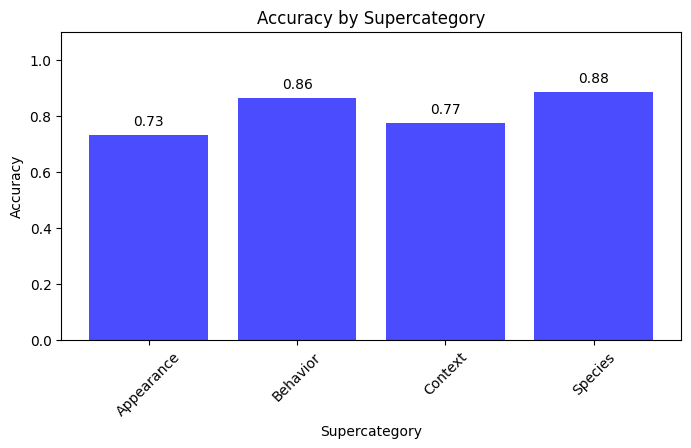

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(supercategory_metrics['supercategory'], supercategory_metrics['accuracy'], color="blue", alpha=0.7)

ax.set_ylabel("Accuracy")
ax.set_xlabel("Supercategory")
ax.set_title("Accuracy by Supercategory")
ax.set_ylim(0, 1.1)  # Accuracy is between 0 and 1

# Add labels directly on bars
ax.bar_label(bars, fmt="%.2f", padding=5)

plt.xticks(rotation=45)
plt.show()

### Precision

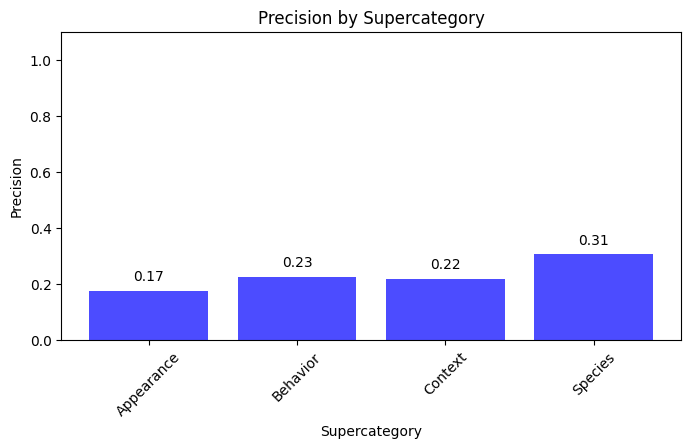

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(supercategory_metrics['supercategory'], supercategory_metrics['precision'], color="blue", alpha=0.7)

ax.set_ylabel("Precision")
ax.set_xlabel("Supercategory")
ax.set_title("Precision by Supercategory")
ax.set_ylim(0, 1.1)  # Precision is between 0 and 1

# Add labels directly on bars
ax.bar_label(bars, fmt="%.2f", padding=5)

plt.xticks(rotation=45)
plt.show()

### Recall

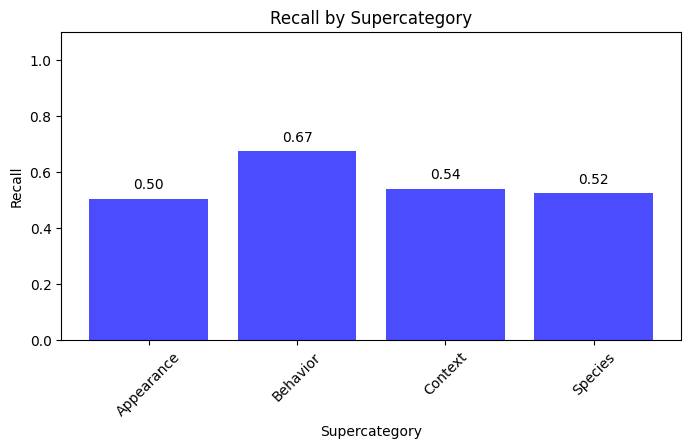

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(supercategory_metrics['supercategory'], supercategory_metrics['recall'], color="blue", alpha=0.7)

ax.set_ylabel("Recall")
ax.set_xlabel("Supercategory")
ax.set_title("Recall by Supercategory")
ax.set_ylim(0, 1.1)  # recall is between 0 and 1

# Add labels directly on bars
ax.bar_label(bars, fmt="%.2f", padding=5)

plt.xticks(rotation=45)
plt.show()

### NDCG

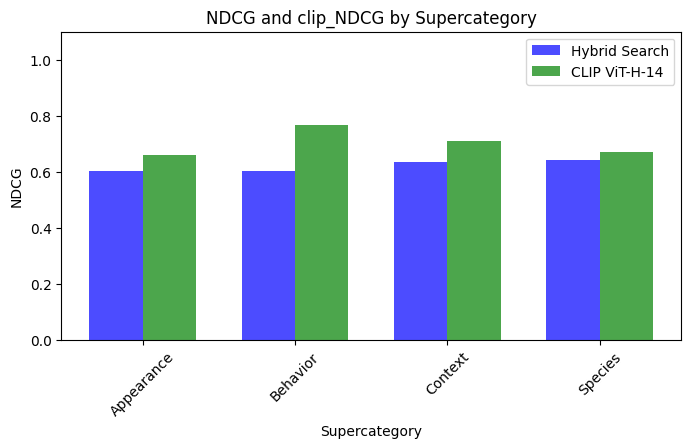

In [9]:
# Creating the plot with both NDCG and clip_NDCG
fig, ax = plt.subplots(figsize=(8, 4))

# Bar width
bar_width = 0.35
x = np.arange(len(supercategory_metrics['supercategory']))

# Bars for NDCG and clip_NDCG
bars1 = ax.bar(x - bar_width/2, supercategory_metrics['NDCG'], width=bar_width, label="Hybrid Search", color="blue", alpha=0.7)
bars2 = ax.bar(x + bar_width/2, supercategory_metrics['clip_NDCG'], width=bar_width, label="CLIP ViT-H-14", color="green", alpha=0.7)

# Labels and title
ax.set_ylabel("NDCG")
ax.set_xlabel("Supercategory")
ax.set_title("NDCG and clip_NDCG by Supercategory")
ax.set_ylim(0, 1.1)
ax.set_xticks(x)
ax.set_xticklabels(supercategory_metrics['supercategory'], rotation=45)
ax.legend()

# Show plot
plt.show()

## Metrics based on Category

In [10]:
# Group by category and calculate the sum/mean of each metric while keeping supercategory
category_metrics = df.groupby(['category']).agg({
    'supercategory': 'first',  # Assuming each category has a single supercategory
    'total_images': 'sum',
    'correctly_returned': 'sum',
    'incorrectly_returned': 'sum',
    'relevant_images': 'sum',
    'non_relevant_images': 'sum',
    'accuracy': 'mean',
    'precision': 'mean',
    'recall': 'mean',
    'NDCG': 'mean',
    'clip_NDCG': 'mean'
}).sort_values(by="supercategory").reset_index()

category_metrics

,category,supercategory,total_images,correctly_returned,incorrectly_returned,relevant_images,non_relevant_images,accuracy,precision,recall,NDCG,clip_NDCG
0,Health and Disease,Appearance,600,454,146,107.0,493.0,0.756667,0.178333,0.447957,0.582461,0.646348
1,Life Cycle and Development,Appearance,750,526,224,129.0,621.0,0.701333,0.172000,0.433572,0.593554,0.559931
2,Sex identification,Appearance,400,279,121,69.0,331.0,0.697500,0.172500,0.388798,0.550514,0.563855
3,Tracking and Identification,Appearance,400,305,95,93.0,307.0,0.762500,0.232500,0.638868,0.753143,0.912170
4,Unique appearances or morphs,Appearance,450,334,116,56.0,394.0,0.742222,0.124444,0.678471,0.548369,0.695488
5,Cooperative and Social Behaviors,Behavior,900,792,108,244.0,656.0,0.880000,0.271111,0.708753,0.612343,0.811939
6,Defensive and Survival Behaviors,Behavior,400,346,54,73.0,327.0,0.865000,0.182500,0.478427,0.553742,0.726746
7,Feeding and Hydration,Behavior,850,724,126,109.0,741.0,0.851765,0.128235,0.707056,0.545995,0.692709
8,"Mating, Courtship, Reproduction",Behavior,550,468,82,138.0,412.0,0.850909,0.250909,0.757851,0.660602,0.782506
9,Miscellaneous Behavior,Behavior,250,216,34,101.0,149.0,0.864000,0.404000,0.556356,0.717353,0.864162


In [11]:
# Define colors for each supercategory
supercategory_colors = {
    "Context": "red",
    "Behavior": "green",
    "Appearance": "blue",
    "Species": "orange"
}

# Assign colors based on supercategory
colors = [supercategory_colors[sc] for sc in category_metrics['supercategory']]

# Bar width
bar_width = 0.35
x = np.arange(len(category_metrics['category']))

### Accuracy

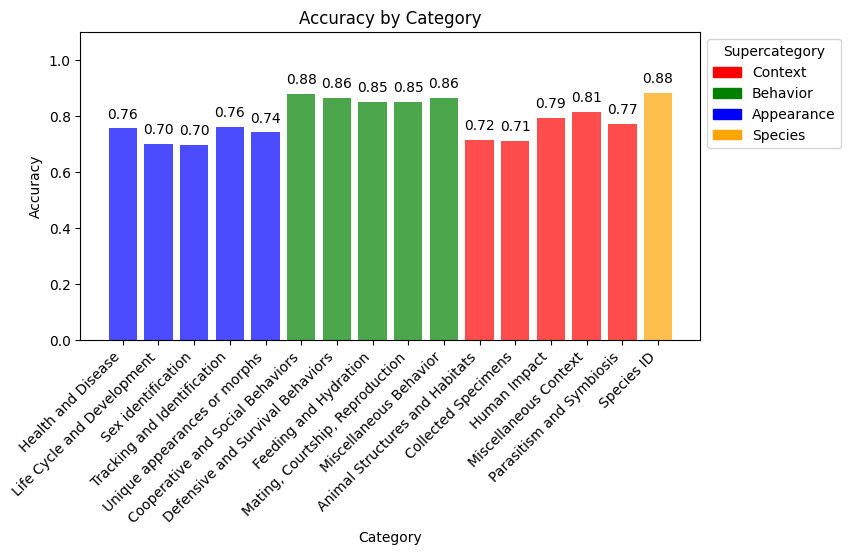

In [12]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Create bars with colors based on supercategory
bars = ax.bar(x, category_metrics['accuracy'], color=colors, alpha=0.7)

ax.set_ylabel("Accuracy")
ax.set_xlabel("Category")
ax.set_title("Accuracy by Category")
ax.set_ylim(0, 1.1)  # Extend limit to prevent overlap with title

# Set x-ticks
ax.set_xticks(x)
ax.set_xticklabels(category_metrics['category'], rotation=45, ha="right")

# Add labels directly on bars
ax.bar_label(bars, fmt="%.2f", padding=5)

# Add legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in supercategory_colors.values()]
ax.legend(handles, supercategory_colors.keys(), title="Supercategory", loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

### Precision

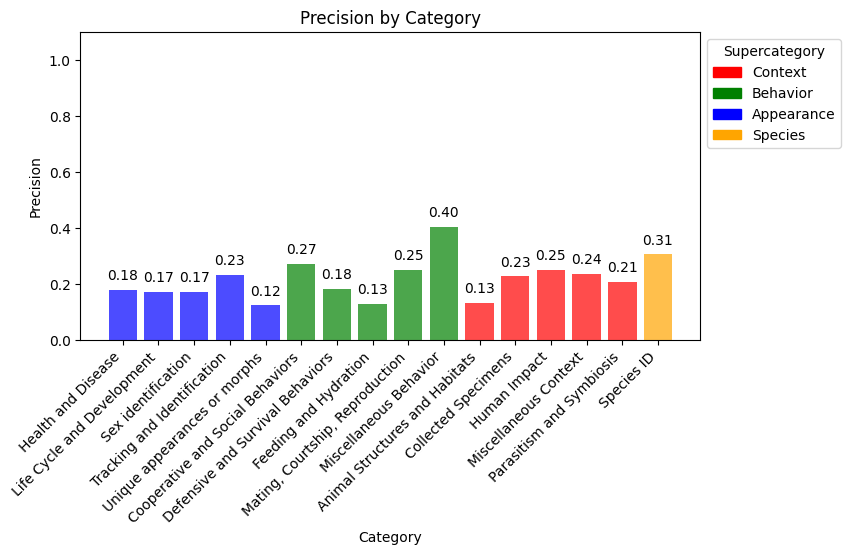

In [13]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Create bars with colors based on supercategory
bars = ax.bar(x, category_metrics['precision'], color=colors, alpha=0.7)

ax.set_ylabel("Precision")
ax.set_xlabel("Category")
ax.set_title("Precision by Category")
ax.set_ylim(0, 1.1)  # Extend limit to prevent overlap with title

# Set x-ticks
ax.set_xticks(x)
ax.set_xticklabels(category_metrics['category'], rotation=45, ha="right")

# Add labels directly on bars
ax.bar_label(bars, fmt="%.2f", padding=5)

# Add legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in supercategory_colors.values()]
ax.legend(handles, supercategory_colors.keys(), title="Supercategory", loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

### Recall

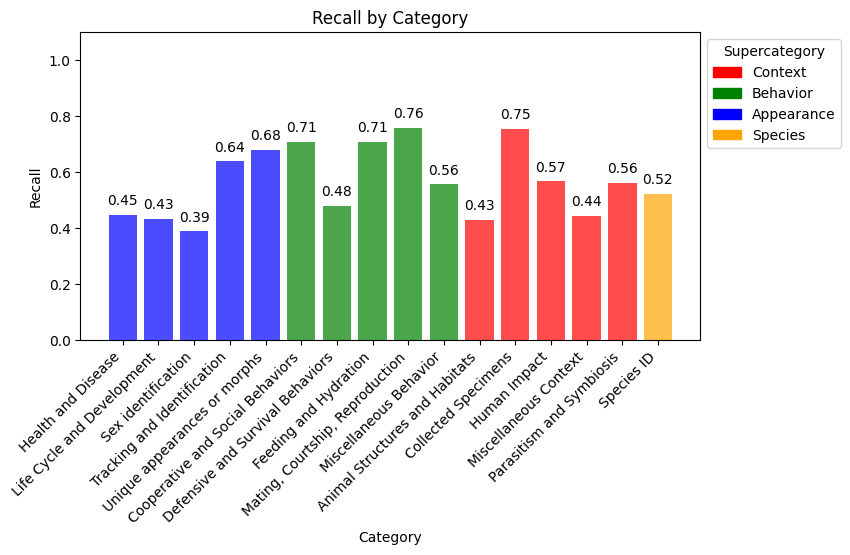

In [14]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Create bars with colors based on supercategory
bars = ax.bar(x, category_metrics['recall'], color=colors, alpha=0.7)

ax.set_ylabel("Recall")
ax.set_xlabel("Category")
ax.set_title("Recall by Category")
ax.set_ylim(0, 1.1)  # Extend limit to prevent overlap with title

# Set x-ticks
ax.set_xticks(x)
ax.set_xticklabels(category_metrics['category'], rotation=45, ha="right")

# Add labels directly on bars
ax.bar_label(bars, fmt="%.2f", padding=5)

# Add legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in supercategory_colors.values()]
ax.legend(handles, supercategory_colors.keys(), title="Supercategory", loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

### NDCG

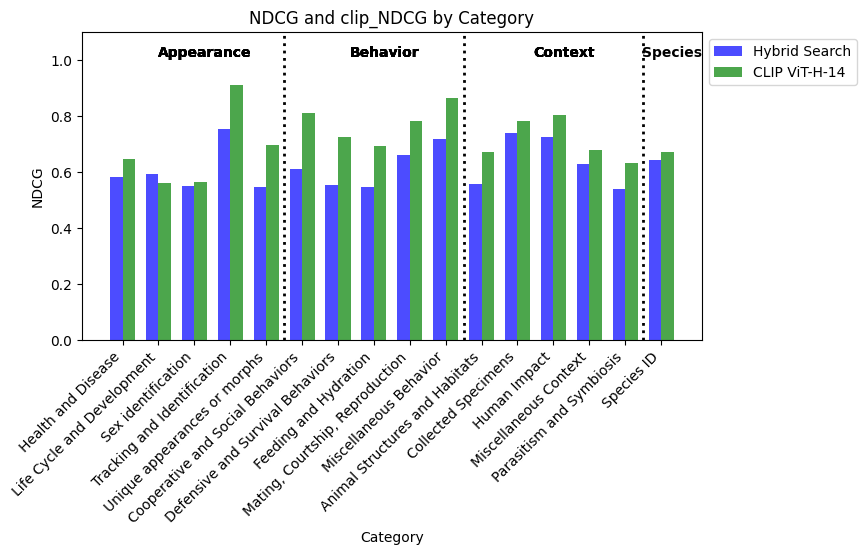

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))

# Create side-by-side bars for NDCG and clip_NDCG
bars1 = ax.bar(x - bar_width/2, category_metrics['NDCG'], width=bar_width,
               label="Hybrid Search", color="blue", alpha=0.7)
bars2 = ax.bar(x + bar_width/2, category_metrics['clip_NDCG'], width=bar_width,
               label="CLIP ViT-H-14", color="green", alpha=0.7)

# Set x-ticks and category labels
ax.set_xticks(x)
ax.set_xticklabels(category_metrics['category'], rotation=45, ha="right")

# add labels and titles
ax.set_ylabel("NDCG")
ax.set_xlabel("Category")
ax.set_title("NDCG and clip_NDCG by Category")
ax.set_ylim(0, 1.1)  # Increase top limit to make room for supercategory labels
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Add dotted vertical lines between supercategory groups
supercats = category_metrics['supercategory'].values
for i in range(1, len(supercats)):
    if supercats[i] != supercats[i-1]:
        # Place line halfway between bars at index i-0.5
        ax.axvline(x=i - 0.5, color='black', linestyle=':', linewidth=2)

# Add supercategory labels above the groups
for supercat in category_metrics['supercategory']:
    # Find indices for current supercategory
    indices = np.where(category_metrics['supercategory'] == supercat)[0]
    # Calculate the center position for the group
    center_x = ((indices[0] + indices[-1]) / 2) + 0.3
    # Add the supercategory label above the bars
    ax.text(center_x, 1.0, supercat, ha='center', va='bottom',
            fontsize=10, fontweight='bold')

plt.show()

## Metrics based on Iconic Group

In [16]:
# Group by iconic_group and calculate the sum/mean of each metric
iconic_metrics = df.groupby(['iconic_group']).agg({
    'total_images': 'sum',
    'correctly_returned': 'sum',
    'incorrectly_returned': 'sum',
    'relevant_images': 'sum',
    'non_relevant_images': 'sum',
    'accuracy': 'mean',
    'precision': 'mean',
    'recall': 'mean',
    'NDCG': 'mean',
    'clip_NDCG': 'mean'
}).reset_index()

iconic_metrics

,iconic_group,total_images,correctly_returned,incorrectly_returned,relevant_images,non_relevant_images,accuracy,precision,recall,NDCG,clip_NDCG
0,Amphibians,200,183,17,31.0,169.0,0.915000,0.155000,0.608683,0.494111,0.560226
1,Animalia,150,134,16,23.0,127.0,0.893333,0.153333,0.535354,0.450975,0.639304
2,Arachnids,350,297,53,52.0,298.0,0.848571,0.148571,0.415760,0.507483,0.638708
3,Birds,2000,1668,332,414.0,1586.0,0.834000,0.207000,0.646762,0.602765,0.732970
4,Combo,50,25,25,21.0,29.0,0.500000,0.420000,0.750000,0.965992,0.964067
5,Fish,350,266,84,62.0,288.0,0.760000,0.177143,0.435263,0.573015,0.651717
6,Fungi,300,239,61,81.0,219.0,0.796667,0.270000,0.427900,0.632267,0.631027
7,Insects,1250,891,359,184.0,1066.0,0.712800,0.147200,0.499641,0.526027,0.615708
8,Mammals,2400,2037,363,635.0,1765.0,0.848750,0.264583,0.666705,0.707476,0.814976
9,Mollusks,200,98,102,39.0,161.0,0.490000,0.195000,0.276532,0.594042,0.675831


In [17]:
# Bar width
bar_width = 0.35
x = np.arange(len(iconic_metrics['iconic_group']))

### Accuracy

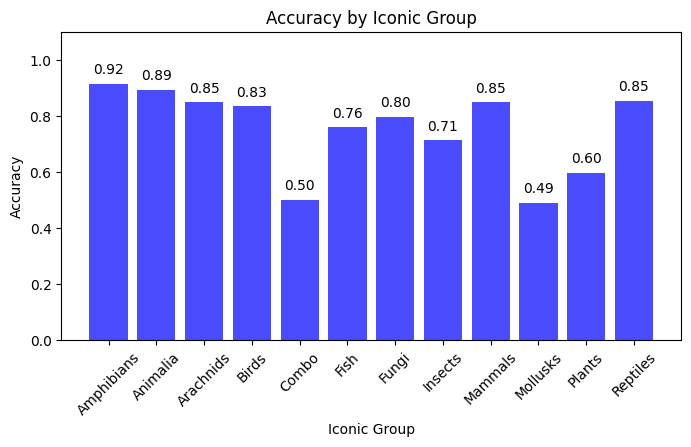

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(iconic_metrics['iconic_group'], iconic_metrics['accuracy'], color="blue", alpha=0.7)

ax.set_ylabel("Accuracy")
ax.set_xlabel("Iconic Group")
ax.set_title("Accuracy by Iconic Group")
ax.set_ylim(0, 1.1)  # Accuracy is between 0 and 1

# Add labels directly on bars
ax.bar_label(bars, fmt="%.2f", padding=5)

plt.xticks(rotation=45)
plt.show()

### Precision

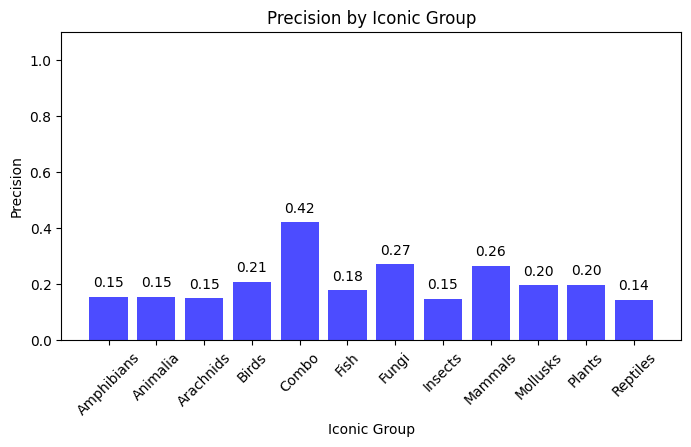

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(iconic_metrics['iconic_group'], iconic_metrics['precision'], color="blue", alpha=0.7)

ax.set_ylabel("Precision")
ax.set_xlabel("Iconic Group")
ax.set_title("Precision by Iconic Group")
ax.set_ylim(0, 1.1)  # Precision is between 0 and 1

# Add labels directly on bars
ax.bar_label(bars, fmt="%.2f", padding=5)

plt.xticks(rotation=45)
plt.show()

### Recall

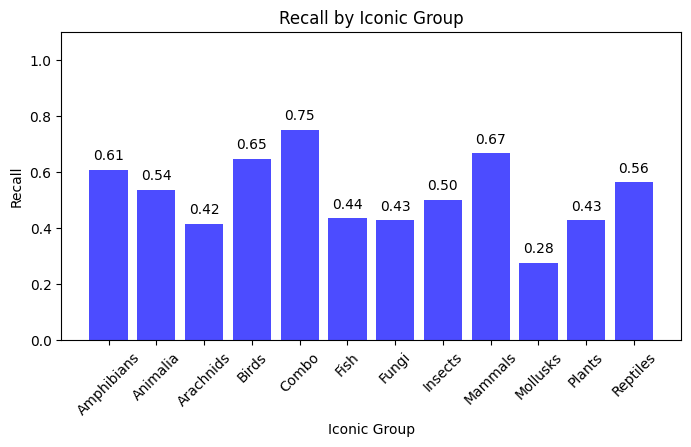

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(iconic_metrics['iconic_group'], iconic_metrics['recall'], color="blue", alpha=0.7)

ax.set_ylabel("Recall")
ax.set_xlabel("Iconic Group")
ax.set_title("Recall by Iconic Group")
ax.set_ylim(0, 1.1)  # recall is between 0 and 1

# Add labels directly on bars
ax.bar_label(bars, fmt="%.2f", padding=5)

plt.xticks(rotation=45)
plt.show()

### NDCG

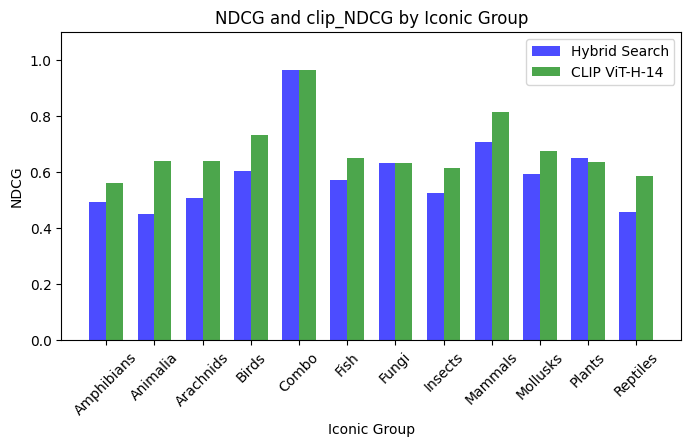

In [21]:
# Creating the plot with both NDCG and clip_NDCG
fig, ax = plt.subplots(figsize=(8, 4))

# Bar width
bar_width = 0.35
x = np.arange(len(iconic_metrics['iconic_group']))

# Bars for NDCG and clip_NDCG
bars1 = ax.bar(x - bar_width/2, iconic_metrics['NDCG'], width=bar_width, label="Hybrid Search", color="blue", alpha=0.7)
bars2 = ax.bar(x + bar_width/2, iconic_metrics['clip_NDCG'], width=bar_width, label="CLIP ViT-H-14", color="green", alpha=0.7)

# Labels and title
ax.set_ylabel("NDCG")
ax.set_xlabel("Iconic Group")
ax.set_title("NDCG and clip_NDCG by Iconic Group")
ax.set_ylim(0, 1.1)
ax.set_xticks(x)
ax.set_xticklabels(iconic_metrics['iconic_group'], rotation=45)
ax.legend()

# Show plot
plt.show()

## Displaying Metrics used in Leaderboard

Here we will show the metrics used in [INQUIRE's leaderboard](https://inquire-benchmark.github.io/) to be able to see how our Hybrid Search is doing when compared to their leaderboard.

In [22]:
ldboard = {
    "Method": "Hybrid Search",
    "Overall": overall_metrics['precision'],
    "Appearance": supercategory_metrics[supercategory_metrics['supercategory']== 'Appearance']['precision'][0],
    "Behavior": supercategory_metrics[supercategory_metrics['supercategory']== 'Behavior']['precision'][1],
    "Context": supercategory_metrics[supercategory_metrics['supercategory']== 'Context']['precision'][2],
    "Species": supercategory_metrics[supercategory_metrics['supercategory']== 'Species']['precision'][3]

}
# Convert the dictionary to a DataFrame
ldboard_df = pd.DataFrame([ldboard])
ldboard_df

,Method,Overall,Appearance,Behavior,Context,Species
0,Hybrid Search,0.21,0.174615,0.225424,0.21814,0.306667


## Comparing to Hybrid Search Baseline(v1)

**System Difference**

* **Baseline:** Hybrid Search uses ImageBind (multi2vec-bind) and keyword fusion with Florence-2 captions.
* **v4:** Introduces **[DFN5B-CLIP-ViT-H-14-378](https://huggingface.co/apple/DFN5B-CLIP-ViT-H-14-378)** embeddings of Florence-2 captions and images to replace ImageBind. This CLIP model is trained on a dataset filtered using a [Data Filtering Network (DFN)](https://arxiv.org/abs/2309.17425) designed to remove noise and improve multimodal alignment.

---

**Overall Metrics Comparison**

| Metric                   | Baseline (v1) | v4 (with CLIP DFN) | Difference |
| ------------------------ | ------------- | ------------------ | ---------- |
| **Total Images**         | 8000          | 8000               | —          |
| **Correctly Returned**   | 5223          | 6371               | ↑ 1148     |
| **Incorrectly Returned** | 2777          | 1629               | ↓ 1148     |
| **Relevant Images**      | 1393.0        | 1680.0             | ↑ 287.0    |
| **Accuracy**             | 0.6529        | 0.7964             | ↑ 0.1435   |
| **Precision**            | 0.1741        | 0.2100             | ↑ 0.0359   |
| **Recall**               | 0.4771        | 0.5766             | ↑ 0.0995   |
| **NDCG**                 | 0.6060        | 0.6123             | ↑ 0.0063   |

---

**Interpretation**

* The v4 system **outperforms the baseline across all metrics**—accuracy, precision, recall, and NDCG—demonstrating a strong improvement in both retrieval quantity and relevance ranking.
* Incorporating **CLIP DFN** results in significantly more relevant images being retrieved with higher precision, and the system is better at ranking those relevant results higher.
* The rise in recall and precision suggests that DFN's cleaner training data improves the model's ability to match scientific image queries effectively.

---

**Insights**

* The DFN-5B dataset appears to be more aligned with the structure and semantics of the INQUIRE benchmark, especially for science-directed imagery.
* This contrasts with the noisier, general-purpose embeddings produced by models like ImageBind, which may not be as finely tuned for ecological and scientific contexts.

---

**Conclusion**

Replacing ImageBind with [DFN5B-CLIP-ViT-H-14-378](https://huggingface.co/apple/DFN5B-CLIP-ViT-H-14-378) embeddings resulted in **clear performance improvements across all evaluation metrics**. This indicates that the DFN-filtered dataset used to train the CLIP model is more suitable for science-specific image search tasks. The enhanced semantic alignment achieved by CLIP DFN likely contributed to more precise and contextually appropriate results, making it a superior choice for the INQUIRE benchmark setup.
